In [1]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings
from time import sleep
import gc

In [2]:
sales=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
categories=pd.read_csv("/kaggle/input/predict-future-sales-eng-translation/categories.csv")
items=pd.read_csv("/kaggle/input/predict-future-sales-eng-translation/items.csv")
shops=pd.read_csv("/kaggle/input/predict-future-sales-eng-translation/shops.csv")
test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")


In [3]:
categories['group_name'] = categories['category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
categories['group_id']  = le.fit_transform(categories.group_name.values)
categories.sample(5)

,category_name,category_id,group_name,group_id
34,Payment Cards - Live! (Digital),34,Payment Cards,14
3,Accessories - PS4,3,Accessories,0
60,Music - Gift editions,60,Music,11
42,"Books - Artbooks, encyclopedias",42,Books,4
20,Games - PS4,20,Games,8


In [4]:
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']
                              
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

items = items.join(categories.set_index('category_id'), on='category_id')
items.sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,item_id,category_id,item_name,item_name_first4,item_name_first6,item_name_first11,category_name,group_name,group_id
15504,15504,63,soft toy pillow wot triangular,3118,5680,10186,Gifts - Soft toys,Gifts,9
7445,7445,55,sax lounge sax collection,2919,5280,9454,Music - CD of local production,Music,11
641,641,78,1c educational collection educational games l...,37,47,68,Programs - Educational (Digit),Programs,16
21686,21686,58,chernavsky yury beyond banana islands 2lp,706,1253,2149,Music - Vinyl,Music,11
10753,10753,40,twelve chairs mzakharov series rem,3431,6285,11217,Cinema - DVD,Cinema,5
3099,3099,58,electric light orchestra zoom limited editio...,1064,1957,3503,Music - Vinyl,Music,11
4320,4320,56,led zeppelin led zeppelin remastered compan...,1841,3310,5964,Music - CD of corporate production,Music,11
16451,16451,37,cloud atlas bd,754,1351,2403,Cinema - Blu-Ray,Cinema,5
9762,9762,37,vedinina gora bd,3532,6415,11424,Cinema - Blu-Ray,Cinema,5
12420,12420,59,kasta kasta dvd,1704,3084,5560,Music - Music video,Music,11


In [5]:
dupes = items[(items.duplicated(subset=['item_name','category_id'],keep=False))]
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
sales = (sales
    .query('0 < item_price < 50000 and 0 < item_cnt_day < 1001') #removing outliers
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's  
    })    
)

sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [7]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.300037,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.605952,60
144,3,28,4,0,4.193211,91
186,4,28,5,0,4.333970,121
228,5,28,6,0,4.472819,152
270,6,28,7,0,4.287644,182
312,7,28,8,0,4.492718,213
354,8,28,9,0,4.313648,244
396,9,28,10,0,4.300037,274


In [8]:

sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum', 
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
725557,16,42,18059,1.0,249.0,5
1101204,26,42,20350,1.0,1099.0,291
1142176,27,59,11914,1.0,799.0,827
1027295,24,42,491,1.0,600.0,3
476721,10,42,11325,1.0,429.0,207


In [9]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,471,0


In [10]:
test['date_block_num'] = 34
del test['ID']

In [11]:
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [12]:
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name','group_name','category_name']), on='item_id', how='left')

In [13]:
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['category_id'].unique()]))),
    columns =['shop_id', 'category_id']
)
temp = df.groupby(['category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on=['shop_id','category_id'], how='left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index='shop_id', columns=['category_id'])
kmeans = KMeans(n_clusters=7, random_state=0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')
shops = shops.join(shops_cats['shop_cluster'], on='shop_id')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [14]:
shops.dropna(inplace=True)

shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

shops['shop_type'] = 'regular'

shops.loc[shops['shop_name'].str.contains(r'tc'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)
shops.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,adygea tc mega,2,0.0,0,0
3,balashikha tc oktyabr kinomir,3,3.0,3,1
4,volga tc volga mall,4,3.0,0,22
5,vologda sec marmelad,5,3.0,2,23
6,voronezh plekhanovskaya 13,6,3.0,2,24


In [15]:
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,2,2,2,8,0.0,0,0
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,415,720,1203,5,0.0,0,0
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,31,38,52,4,0.0,0,0
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,31,38,57,4,0.0,0,0
4,2,471,0,2.0,798.0,3.0,1,0,4.381749,1,49,30,37,51,4,0.0,0,0


In [16]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day'],[0]*len(df))]
del df['first_day_of_month']

In [17]:
del sales, categories, shops, shops_cats, temp, temp2, test, dupes, item_map, 
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381749,19,2,2,2,8,0.0,0,0,0
1,2,33,0,1.0,499.0,2,1,0,4.381749,37,415,720,1203,5,0.0,0,0,0
2,2,317,0,1.0,299.0,4,1,0,4.381749,45,31,38,52,4,0.0,0,0,0
3,2,438,0,1.0,299.0,19,1,0,4.381749,45,31,38,57,4,0.0,0,0,0
4,2,471,0,2.0,798.0,3,1,0,4.381749,49,30,37,51,4,0.0,0,0,0


In [18]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

In [19]:
def downcast(df):
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

In [20]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('group_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [21]:
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

In [22]:
def agg_cnt_col(df, merging_cols, new_col,aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 

df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'}) 

df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})

df = agg_cnt_col(df, ['date_block_num','group_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','group_id'],'group_cnt_all_shops',{'item_cnt':'mean'})

df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})

df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

In [23]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df


df = new_item_sales(df, ['date_block_num','category_id','shop_id'], 'new_items_in_cat')

df = new_item_sales(df, ['date_block_num','category_id'], 'new_items_in_cat_all_shops')


In [24]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df


df = agg_price_col(df,['date_block_num','item_id'],'item_price')
df = agg_price_col(df,['date_block_num','category_id'],'category_price')
df = agg_price_col(df,['date_block_num'],'block_price')

In [25]:
df = downcast(df)

In [26]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

In [27]:
lag12_cols = {
    'item_cnt':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops':['date_block_num', 'item_id'],
    'category_cnt':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops':['date_block_num', 'category_id'],
    'group_cnt':['date_block_num', 'shop_id', 'group_id'],
    'group_cnt_all_shops':['date_block_num', 'group_id'],
    'shop_cnt':['date_block_num', 'shop_id'],
    'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'category_id']
}
for col,merge_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to12'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

In [28]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops_median':['date_block_num', 'item_id'],
    'category_cnt_median':['date_block_num', 'shop_id', 'category_id'],
    'category_cnt_all_shops_median':['date_block_num', 'category_id']
}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_cnt_unclipped':
        del df[col]

In [29]:
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1']/df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_lag1']/df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_lag1']/df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_lag1']/df['category_cnt_all_shops_lag1to12']

In [30]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

In [31]:
df.loc[(df['item_age']>0) & (df['item_cnt_lag1to12'].isna()), 'item_cnt_lag1to12'] = 0
df.loc[(df['category_age']>0) & (df['category_cnt_lag1to12'].isna()), 'category_cnt_lag1to12'] = 0
df.loc[(df['group_age']>0) & (df['group_cnt_lag1to12'].isna()), 'group_cnt_lag1to12'] = 0

In [32]:
df['item_cnt_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[12]*len(df))]
df['item_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],[12]*len(df))]
df['category_cnt_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['category_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]
df['group_cnt_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[12]*len(df))]
df['group_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],[12]*len(df))]
df['city_cnt_lag1to12'] /= [min(idx) for idx in zip(df['date_block_num'],[12]*len(df))]
df['shop_cnt_lag1to12'] /= [min(idx) for idx in zip(df['shop_age'],[12]*len(df))]
df['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]

In [33]:
df = downcast(df)

In [34]:

def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
df = past_information(df, ['shop_id','item_id'],'item_cnt_sum_alltime',{'item_cnt':'sum'})
df = past_information(df, ['item_id'],'item_cnt_sum_alltime_allshops',{'item_cnt':'sum'})

del df['revenue'], df['item_cnt_unclipped'], df['item_price']

In [35]:
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']

In [36]:
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [37]:
import gc
gc.collect()
df = downcast(df)

In [38]:
def matching_name_cat_age(df,n,all_shops):
    temp_cols = [f'same_name{n}catage_cnt','date_block_num', f'item_name_first{n}','item_age','category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_cnt':'mean'})
            .reset_index()
            .rename(columns={'item_cnt':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')
    return df

for n in [4,6,11]:
    for all_shops in [True,False]:
        df = matching_name_cat_age(df,n,all_shops)


In [39]:
df = downcast(df)
int8_cols = [
    'item_cnt','month','group_id','shop_type',
    'shop_city','shop_id','date_block_num','category_id',
    'item_age',
]
int16_cols = [
    'item_id','item_name_first4',
    'item_name_first6','item_name_first11'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

In [40]:
def nearby_item_data(df,col):
    if col in ['item_cnt_unclipped_lag1','item_cnt_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_cnt_unclipped_lag1','item_cnt_lag1to12',
             'item_cnt_all_shops_lag1','item_cnt_all_shops_lag1to12']
for col in item_cols:
    df = nearby_item_data(df,col)
    
del temp

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()
for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
drop_cols = [
    'item_id','category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11',
    'category_name','group_name','group_id'
]
items = items.drop(columns=drop_cols)

In [42]:
df = df.join(items, on='item_id')

In [43]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 14)
    
del df['item_name_first4'], df['item_name_first6']

In [44]:
df.to_pickle('df_complete.pkl')

In [45]:
%reset -f

In [46]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 30)

import warnings
warnings.filterwarnings("ignore")

In [47]:
df = pd.read_pickle('/kaggle/working/df_complete.pkl')

X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt']
del X_train['item_cnt']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt']
del X_val['item_cnt']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt')
X_test = X_test.reset_index()
del X_test['index']

del df

In [48]:
import gc
gc.collect()

23

In [ ]:
# def cv_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_val = lgb.Dataset(X_val, y_val)
#     cv_lgb = lgb.cv(params, lgtrain, num_boost_round=700, nfold=3, 
#     return cv_lgb

In [ ]:
# cv_lgb = lgb.cv(params, lgtrain, num_boost_round=700, nfold=3, 
#                     verbose_eval=20, early_stopping_rounds=40)

In [51]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [52]:
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

lgb_model.save_model('lgb_model.txt')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 10.442137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14912
[LightGBM] [Info] Number of data points in the train set: 7795360, number of used features: 154
[LightGBM] [Info] Start training from score 0.312795
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.979055	valid_1's rmse: 0.895859
[100]	training's rmse: 0.838971	valid_1's rmse: 0.810964
[150]	training's rmse: 0.763975	valid_1's rmse: 0.773744
[200]	training's rmse: 0.721517	valid_1's rmse: 0.757033
[250]	training's rmse: 0.694202	valid_1's rmse: 0.750594
[300]	training's rmse: 0.674361	valid_1's rmse: 0.746876
[350]	training's rmse: 0.659041	valid_1's rmse: 0.745105
[400]	training's rmse: 0.646289	valid_1's rmse: 0.744061
[450]	training's rmse: 0.635136	valid_1's rmse: 0.743747
Early stopping, best iteration is:
[442]	training's rmse: 0.636779	valid_1's 

In [54]:
submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
submission['item_cnt_month'] = lgb_model.predict(X_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

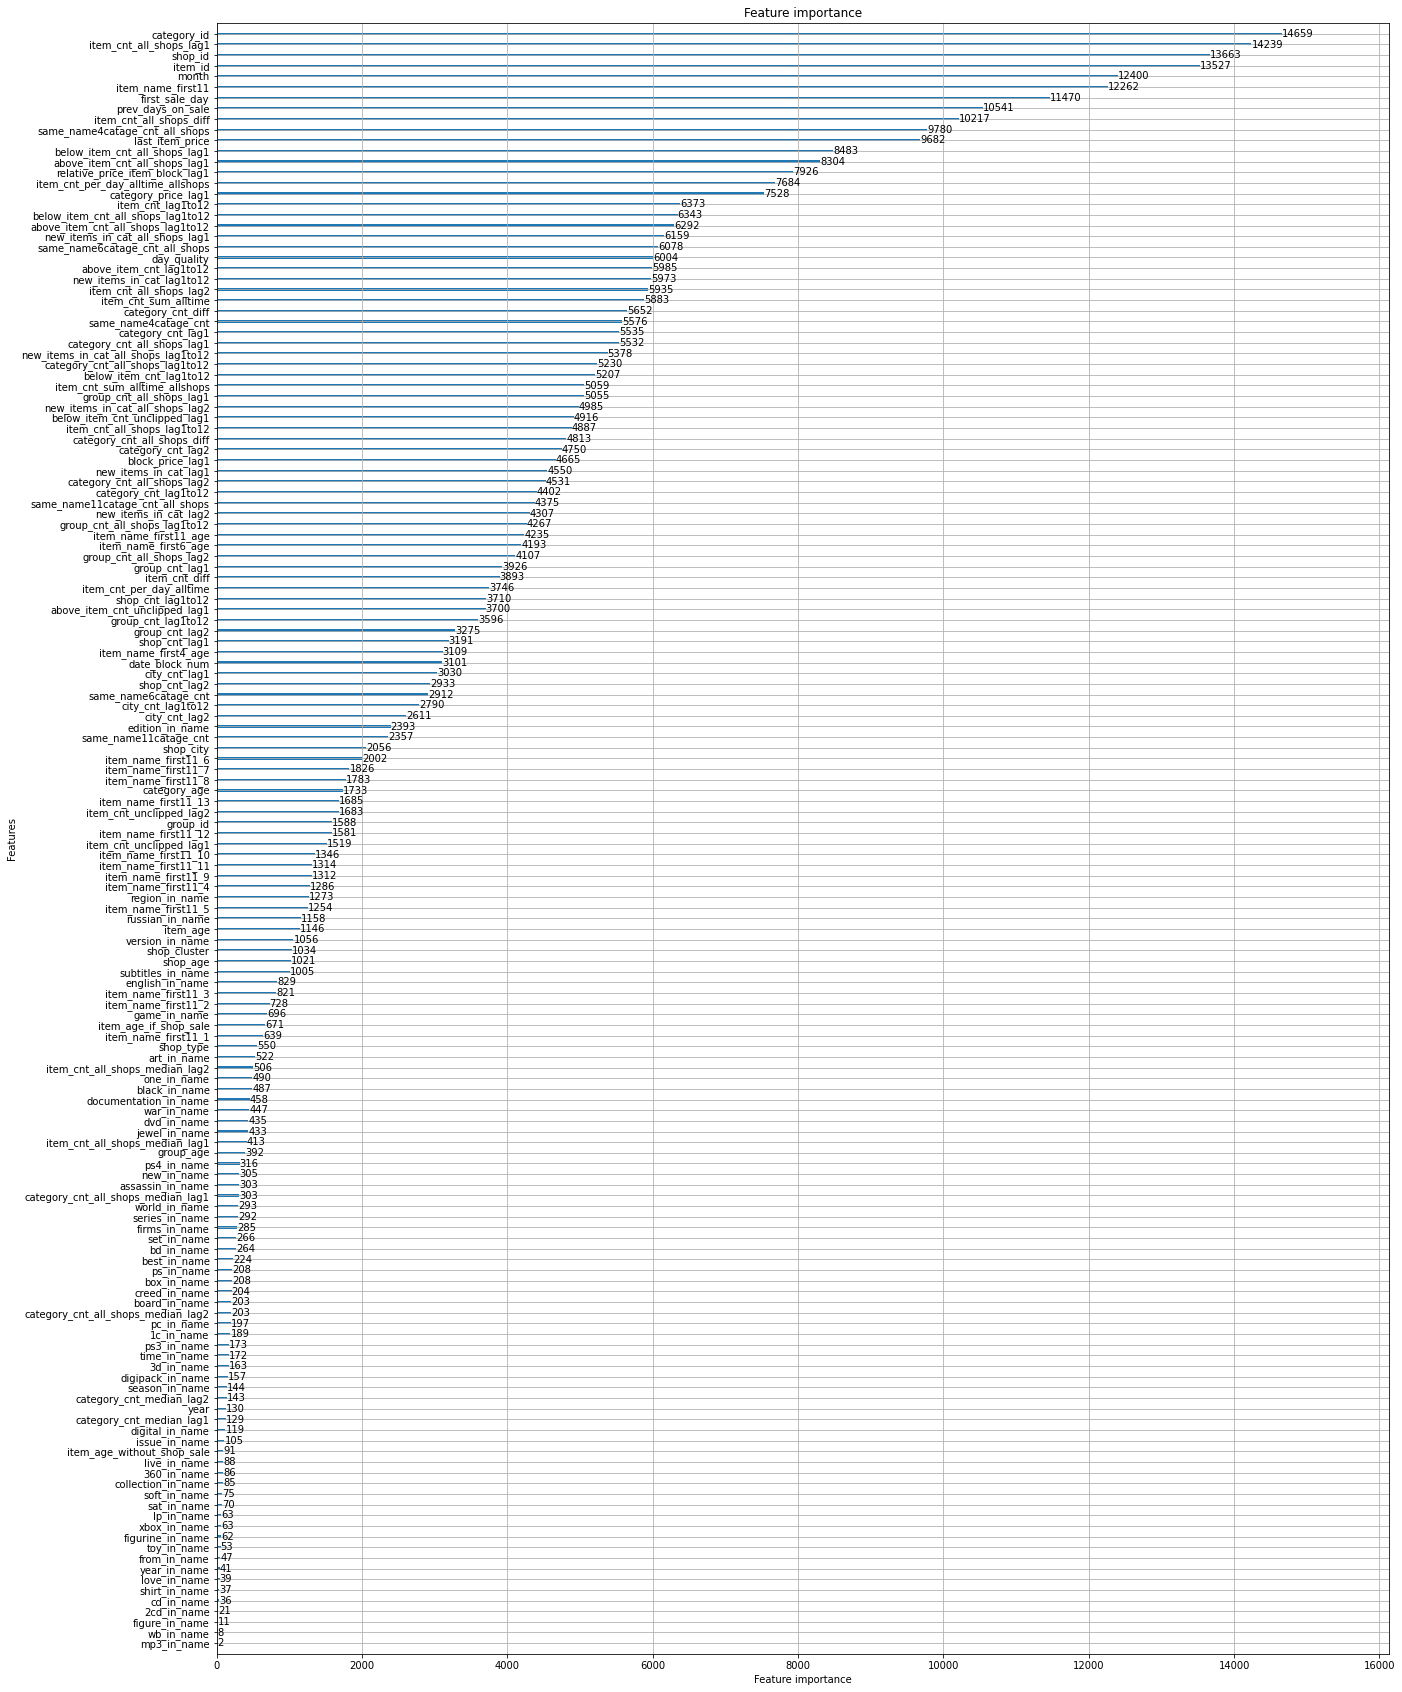

In [53]:
lgb.plot_importance(lgb_model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', max_num_features=None, ignore_zero=True, figsize=(21,30),  grid=True, precision=3)

In [58]:
#lr_set=df[cat_features]
cat_features=['category_id','month','shop_id','shop_city','item_cnt_all_shops_lag1','item_name_first11']
             #'first_sale_day','prev_days_on_sale','category_price_lag1','day_quality']
lr_train=X_train[cat_features]
lr_val=X_val[cat_features]
lr_test=X_test[cat_features]

In [59]:
from sklearn.preprocessing import MinMaxScaler

lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [60]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression(n_jobs=-1)
lr_model=lr_model.fit(lr_train,y_train)


In [61]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [62]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, lr_val_pred)))

Train rmse: 1.0896745
Validation rmse: 0.9967483


In [64]:
submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
submission['item_cnt_month'] = lr_model.predict(lr_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('lr_submission.csv', index=False)

In [49]:
from sklearn.ensemble import RandomForestRegressor
rf_features=['category_id','month','shop_id','shop_city','item_cnt_all_shops_lag1','item_name_first11',
             'first_sale_day','prev_days_on_sale','category_price_lag1','day_quality']
rf_train=X_train[rf_features]
rf_val=X_val[rf_features]
rf_test=X_test[rf_features]

In [51]:
from sklearn.model_selection import RandomizedSearchCV
mdl=RandomForestRegressor()
param={'n_estimators':[25,50],'max_depth':[4,6,8]}
cl= RandomizedSearchCV(mdl,param_distributions=param,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error',random_state=0,return_train_score=True)
cl.fit(rf_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8],
                                        'n_estimators': [25, 50]},
                   random_state=0, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [52]:
print(cl.best_score_)
print(cl.best_params_)

-0.9949366309910144
{'n_estimators': 50, 'max_depth': 8}


In [50]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=0, n_jobs=-1)
rf_model.fit(rf_train,y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, n_jobs=-1, random_state=0)

In [51]:
rf_test_pred = rf_model.predict(rf_test)
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)

In [55]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, rf_val_pred)))

Train rmse: 0.9666596404779015
Validation rmse: 0.9059379484896861


In [52]:
submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
submission['item_cnt_month'] = rf_model.predict(rf_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('rf_submission.csv', index=False)

In [65]:
from prettytable import PrettyTable
pt=PrettyTable(["Model","Train MSE","Validation MSE","Test MSE"])
pt.add_row(["LGB", "0.63", "0.74", "0.85446"])
pt.add_row(["LinerRegressor", "1.08", "0.99", "1.19"])
pt.add_row(["RandomForestRegressor", "0.96", "0.90", "0.99"])
print(pt)

+-----------------------+-----------+----------------+----------+
|         Model         | Train MSE | Validation MSE | Test MSE |
+-----------------------+-----------+----------------+----------+
|          LGB          |    0.63   |      0.74      | 0.85446  |
|     LinerRegressor    |    1.08   |      0.99      |   1.19   |
| RandomForestRegressor |    0.96   |      0.90      |   0.99   |
+-----------------------+-----------+----------------+----------+
